In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")


In [3]:
df.drop('Person ID', axis=1, inplace=True)

In [4]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


Splitting Blood Pressure into Two Features

In [5]:
df['High_pressure'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[0]))
df['Low_pressure'] = df['Blood Pressure'].apply(lambda x: int(x.split('/')[1]))
df.drop("Blood Pressure", axis=1, inplace=True)


 Cleaning BMI Categories

In [6]:
df.loc[df["BMI Category"] == "Normal Weight", "BMI Category"] = "Normal"
df.loc[df["BMI Category"] == "Obese", "BMI Category"] = "Overweight"

Merging Rare Occupations as 'unknown'

In [7]:
cut_off = 20
value_counts = df['Occupation'].value_counts()
rare_occupations = value_counts[value_counts < cut_off].index
df['Occupation'] = df['Occupation'].replace(rare_occupations, 'Unknown')


Dropping Missing Values

In [8]:
df.fillna(value='no' ,inplace=True)

In [9]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,High_pressure,Low_pressure
0,Male,27,Unknown,6.1,6,42,6,Overweight,77,4200,no,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,no,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,no,125,80
3,Male,28,Unknown,5.9,4,30,8,Overweight,85,3000,Sleep Apnea,140,90
4,Male,28,Unknown,5.9,4,30,8,Overweight,85,3000,Sleep Apnea,140,90


Encoding Categorical Variables

In [10]:
le = LabelEncoder()
for col in ['Gender', 'Occupation', 'BMI Category']:
    df[col] = le.fit_transform(df[col])


Encode target variable

In [11]:
target_encoder = LabelEncoder()
df['Sleep Disorder'] = target_encoder.fit_transform(df['Sleep Disorder'])

Preparing Features and Target

In [12]:
X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

Splitting the Dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SCALING NUMERIC FEATURES

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

FEATURE SELECTION

In [15]:
selector = SelectKBest(score_func=f_classif, k=8)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))

Selected Features: ['Age', 'Occupation', 'Sleep Duration', 'Physical Activity Level', 'BMI Category', 'Daily Steps', 'High_pressure', 'Low_pressure']


TRAINING LOGISTIC REGRESSION

In [16]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000, random_state=42)

PREDICTION & EVALUATION

In [17]:
y_pred = model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))


Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.74      0.88      0.80        16
 Sleep Apnea       0.92      0.75      0.83        16
          no       0.93      0.93      0.93        43

    accuracy                           0.88        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.89      0.88      0.88        75



Training a Random Forest Classifier

In [18]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Predicting and Calculating Accuracy

In [19]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


Displaying Evaluation Report

In [20]:
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_encoder.classes_))


Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
 Sleep Apnea       0.85      0.69      0.76        16
          no       0.95      0.98      0.97        43

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



Confusion Matrix

<Axes: >

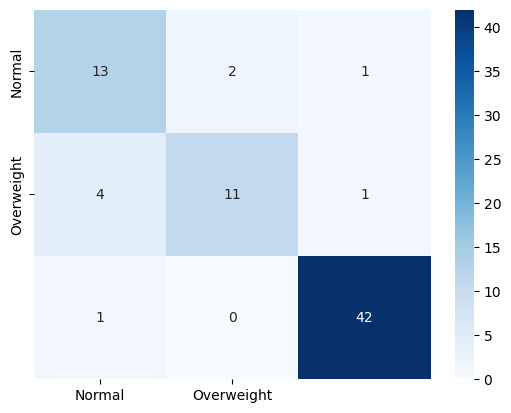

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)


Feature Importance Chart

<Axes: title={'center': 'Feature Importance'}>

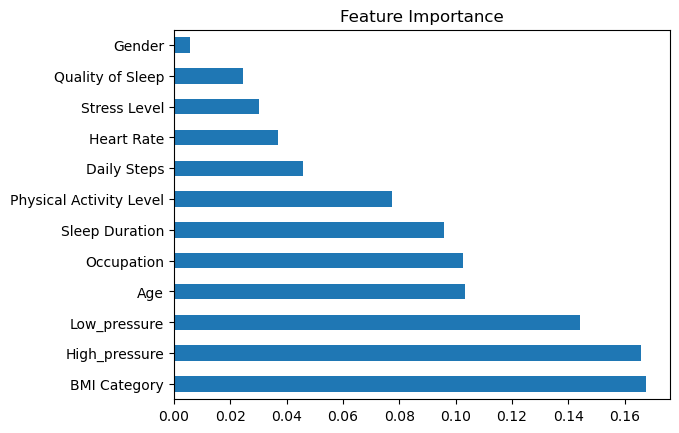

In [22]:
feat_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importance.plot(kind='barh', title='Feature Importance')


In [23]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Map labels
label_map = {"None": 0, "Insomnia": 1, "Sleep Apnea": 2}
df = df[df["Sleep Disorder"].notnull()]
df["Sleep Disorder"] = df["Sleep Disorder"].map(label_map)

# Split features and labels
X = df.drop("Sleep Disorder", axis=1)
y = df["Sleep Disorder"]

# One-hot encode
X_encoded = pd.get_dummies(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Save everything
joblib.dump(model, "sleep_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_encoded.columns.tolist(), "features.pkl")

['features.pkl']